<a href="https://colab.research.google.com/github/siddharth1608/datascience/blob/master/deep_learning/Pytorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Handwritten Digit Classifier using CNN in Pytorch ##

In this notebook, I walk you through my understanding about Convolutional Neural Networks(CNNs) and how it is implemented in Pytorch


---


**CNN are specialized for image processing. Why?**

The architecture of a simple feed forward neural network consists of densely connected layers. By dense, I mean every node in the previous layer is connected to every node in the current layer. This complex nature allows to learn intricate functions from data. 

However, this architecture is not favourable for images. Imagine a 28 x 28 pixels image, fed into a neural network and passed through the layers. To learn the functions from every pixel, we would need extremely large number of nodes and it sounds like a computational nightmare to learn the network parameters. Enter, **CNN**.

CNNs main idea is **convolution** operation.  Convolution is nothing but a tiny matrix(also called filter) that slides over the whole image and extracts features from a group of neighbouring pixels. For e.g. a network can learn weights for a filter to detect a circle in the image that would increase probability of 6, 8 or 9 in the image.

A CNN network may contain multiple filters spread across multiple layers

After, convolution, **pooling** is applied which is obtaining a summary value for a group of values. Popular pooling used is MaxPooling, which simply passes through the maximum value in a grid.

With the help of convolution and pooling, CNNs summarize information instead of looking at every pixel.

Now, lets see the implementation of CNN in Pytorch

In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import PIL.Image as pil
from matplotlib import pyplot as plt

print(torch.__version__)

1.0.1.post2


In [0]:
# Hyperparameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [0]:
import pandas as pd
train_dataset = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
test_dataset = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)

In [5]:
print('Train shape {}, Test shape {}'.format(train_dataset.shape, test_dataset.shape))

Train shape (20000, 785), Test shape (10000, 785)


View sample images

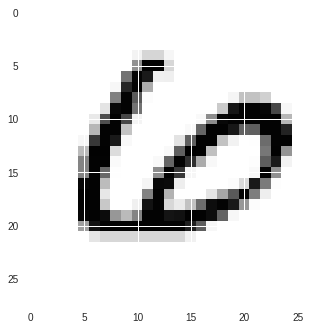

In [7]:
first_image = train_dataset.iloc[0][1:].values.reshape(28,28).astype('uint8')

### Using PIL
#img = pil.fromarray(np.uint8(first_image * 255) , 'L')
#img

### Using matplot
plt.imshow(first_image)

The dataset has first column as the label. and image data as flattened, 784 cells - we need to make it in grid shape of size 28 x 28

In order to load our custom dataset into Pytorch and use DataLoader we have to inherit torch.DataSet class

In [0]:
class CustomMNISTDatasetFromCSV(Dataset):
  def __init__(self, file_path, image_height, image_width, transforms=None):
    self.data = pd.read_csv(file_path, header=None)
    self.labels = self.data.iloc[:,0]
    self.image_height = image_height
    self.image_width = image_width
    self.transforms = transforms
    
  def __getitem__(self, index):
    image_label = self.labels[index]
    image_as_np_arr = np.asarray(self.data.iloc[index][1:]).reshape(self.image_height, self.image_width).astype('uint8')
    # uint8 - unsigned int, 0-255
    
    if self.transforms is not None:
        img_as_tensor = self.transforms(image_as_np_arr)
        
    return (img_as_tensor, image_label)
  
  def __len__(self):
    return len(self.data.index)

In [0]:
# Define transforms
transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# Define custom dataset
train_mnist_from_csv = CustomMNISTDatasetFromCSV('/content/sample_data/mnist_train_small.csv',28, 28,
                         transformations)

test_mnist_from_csv = CustomMNISTDatasetFromCSV('/content/sample_data/mnist_test.csv',28, 28,
                         transformations)

train_loader = DataLoader(dataset=train_mnist_from_csv, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_mnist_from_csv, batch_size=batch_size, shuffle=False)

Now, we will create the Layers for our Convolutional Neural network

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__();
    
    # Our first layer would consists of 
    # 1. Convolution Layer: 32 filters/channels of size 5x5 and stride of 1(slide unit)
    # 2. Relu Layer
    # 3. Pooling Layer
    
    self.layer1 = nn.Sequential(
                      nn.Conv2d(1, 32, kernel_size=5, stride = 1, padding =2),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride = 2)
                  )
    
    # Our second layer would consist of similar structure except that input will be 32 channels and output will be 
    # 64 channels
    self.layer2 = nn.Sequential(
                      nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size =2, stride =2)
                  )
    
    self.dropout = nn.Dropout()
    
    # Fully connected Layer network to flatten the channels - '7 * 7'(image size) * 64(no of channels)
    self.fc1 = nn.Linear(7*7*64, 1000)
    
    # Last layer to assign values to labels, 0-9
    self.fc2 = nn.Linear(1000, 10)
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)

    # Below we Reshape the layer2 output with Number of rows and unknown columns. This will flatten the 7 * 7 images of every 64 channels
    out = out.reshape(out.shape[0],-1) 

    out = self.fc1(out)
    out = self.fc2(out)

    return out

**How is the padding decided ?**

${W_{out} = {\frac{W_{in}-F + 2P}{S}} + 1  }$

${W_{out} } $ is the dimension of output after convolution

${ W_{in} } $ is the dimension of the input. 

${F}$ : Filter size

${S }$: Stride

${P}$: Padding

We want to apply a filter 5 x5 and with a stride of 1. Also we want the input and output of same dimensions so we plug in these values in the above formula which suggests us to use Padding of 2.

The same formula can be used to find padding for Pooling operation. We want to down sample the images from 28 \* 28 to 14 \* 14, which can be achieved by using a padding of 0

**Model Training**

In [0]:
model = CNN()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/200], Loss: 0.1386, Accuracy: 93.00%
Epoch [1/5], Step [200/200], Loss: 0.1327, Accuracy: 97.00%
Epoch [2/5], Step [100/200], Loss: 0.0497, Accuracy: 99.00%
Epoch [2/5], Step [200/200], Loss: 0.0406, Accuracy: 98.00%
Epoch [3/5], Step [100/200], Loss: 0.0782, Accuracy: 99.00%
Epoch [3/5], Step [200/200], Loss: 0.0466, Accuracy: 98.00%
Epoch [4/5], Step [100/200], Loss: 0.0116, Accuracy: 100.00%
Epoch [4/5], Step [200/200], Loss: 0.0455, Accuracy: 99.00%
Epoch [5/5], Step [100/200], Loss: 0.0124, Accuracy: 100.00%
Epoch [5/5], Step [200/200], Loss: 0.1364, Accuracy: 96.00%


**Test the model**

In [0]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


Test Accuracy of the model on the 10000 test images: 97.92 %
